# CPI Analysis

In [52]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram

## Define function

In [ ]:
def read_data(filename):
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
    df.set_index('Date', inplace=True)

    name = os.path.splitext(os.path.basename(filename))[0]

    return df.copy(), name.capitalize()

In [ ]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [59]:
def seasonal_analyze(data, name, save_file_name, period, time_flag, model, save=False):
    if len(data) == 0: return
    target_name = f"{'' if name == 'CPI' else 'CPI of'} {name}"
    base_path = f"../out/img/{name}"
    save_path = f"{base_path}/{save_file_name}"
    os.makedirs(save_path, exist_ok=True)

    plt.figure(figsize=(15, 6.4))
    plt.plot(data, linestyle="-", label=target_name)
    plt.title(f"{name} in {time_flag}")
    if save: plt.savefig(f"{save_path}/{save_file_name}-Observation")
    plt.show()

    frequencies, spectrum = periodogram(data)
    plt.figure(figsize=(15, 6.4))
    plt.plot(frequencies, spectrum)
    plt.xlabel('Frequency')
    plt.ylabel('Spectral Density')
    plt.title(f'Periodogram of {target_name} in {time_flag}')
    if save: plt.savefig(f"{save_path}/{save_file_name}-Periodogram")
    plt.show()

    season = seasonal_decompose(data, model=model, period=period)
    fig = season.plot()
    fig.suptitle(f"Seasonal Decomposition of {target_name} in {time_flag}")
    fig.set_figwidth(15)
    fig.set_figheight(6.4)
    plt.tight_layout()
    if save: plt.savefig(f"{save_path}/{save_file_name}-Seasonal")
    plt.show()


    fig, ax = plt.subplots(1, 2)
    plot_acf(data, ax=ax[0])
    plot_pacf(data, ax=ax[1])
    fig.set_figwidth(15)
    fig.set_figheight(6.4)
    plt.tight_layout()
    if save: plt.savefig(f"{save_path}/{save_file_name}-Correlation")
    plt.show()

## Input data

### Read data list

In [ ]:
data_files = glob.glob("..\\data\\*.csv")
data_files

### Read file

In [44]:
df, name = read_data("../data/random.csv")

In [45]:
df.describe()

,Value,Change
count,252.000000,252.000000
mean,150.655040,0.241071
std,28.259504,39.086562
min,100.650000,-86.080000
25%,125.695000,-26.252500
50%,150.925000,1.105000
75%,176.372500,25.550000
max,199.900000,84.390000


### Preprocess data

In [46]:
df.dropna(inplace=True)
df.count() - len(df)

Value     0
Change    0
dtype: int64

## Analysis

### Stationarity test

Use Dickey-Fuller test to judge if the dataset is stationary or not

The smaller p-value, the better

If the p-value is too large, differencing the data will fix (maybe)

In [ ]:
test_stationarity(df["Value"])

#### Differencing the data

In [ ]:
for _ in range(1): #differencing
    df['Value'] = df['Value'].diff()

df = df.dropna()
df['Value'].head()

### Seasonal decomposition

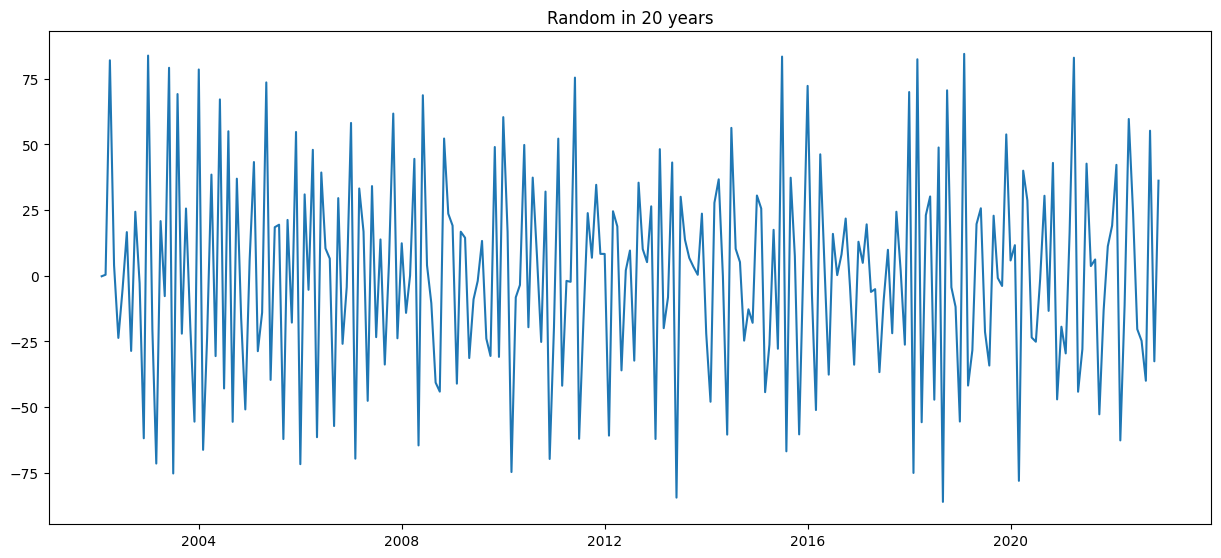

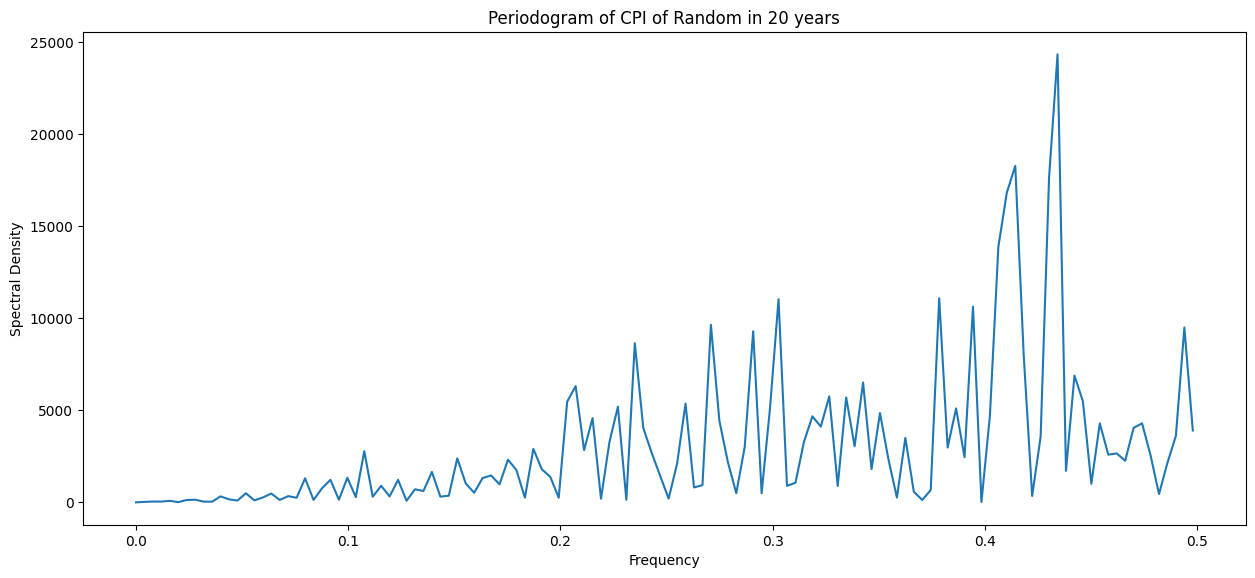

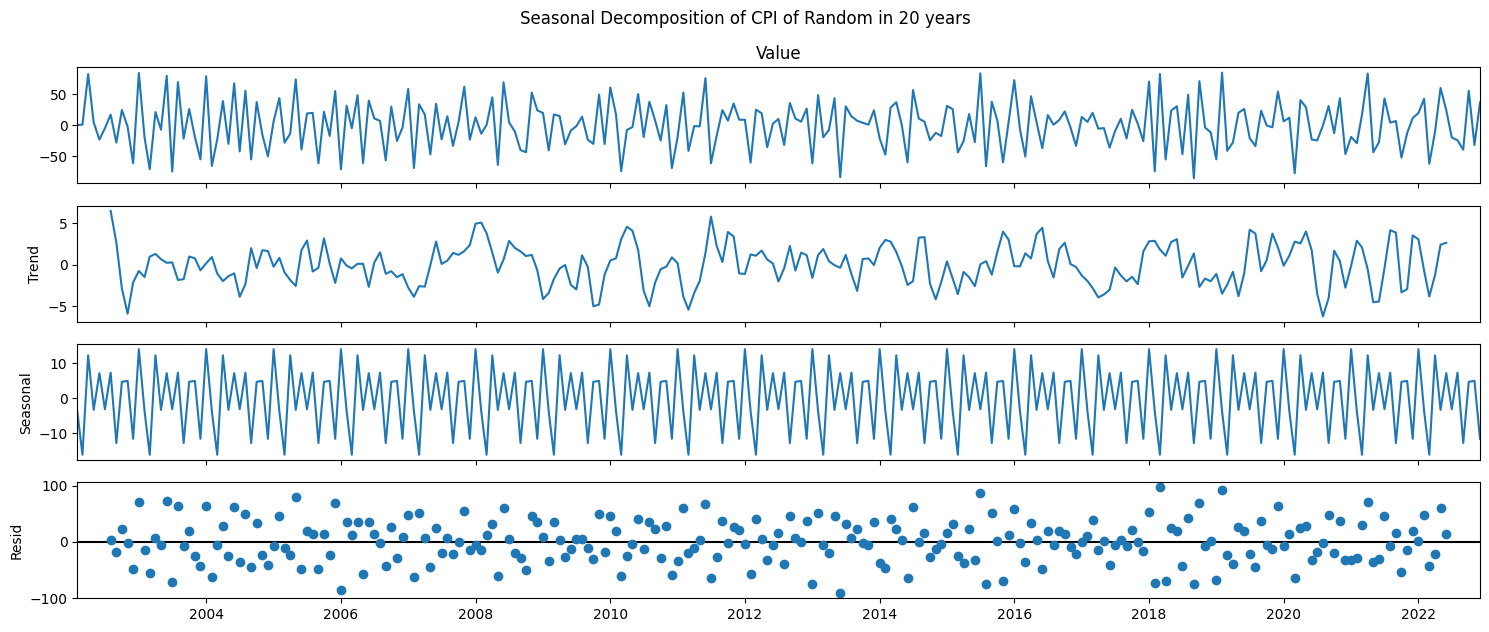

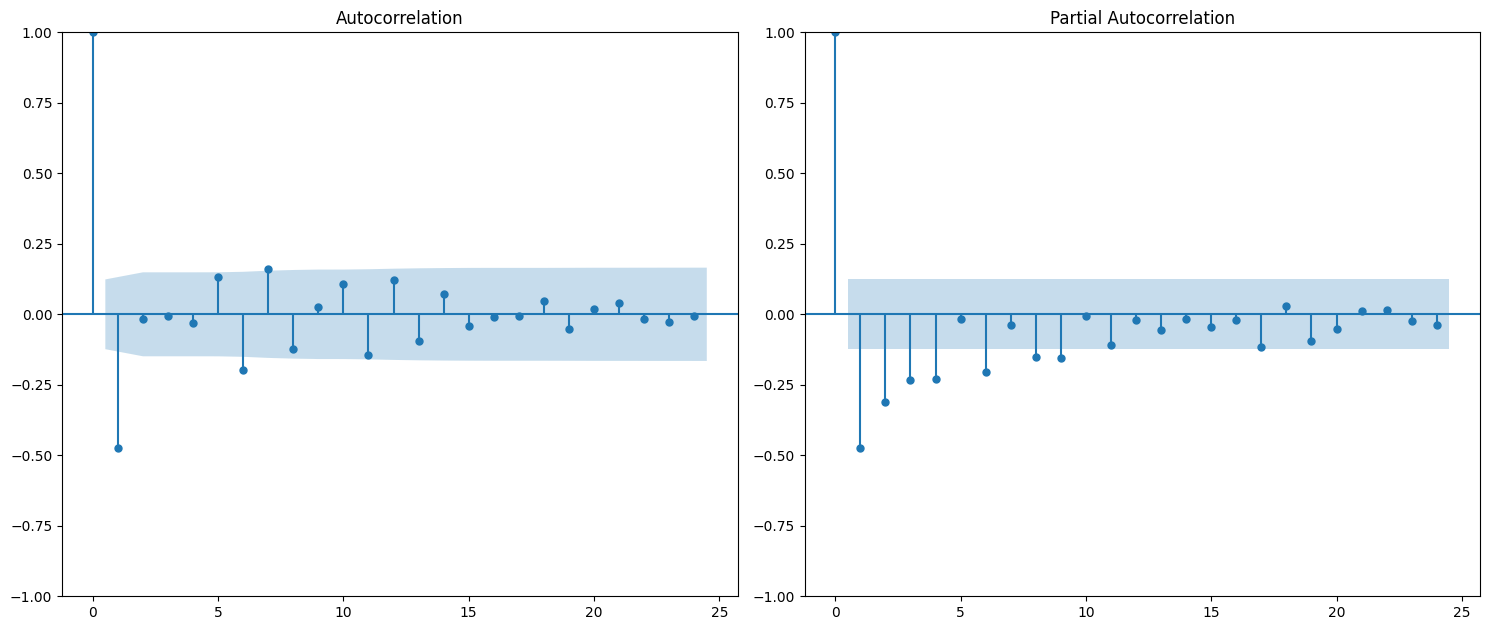

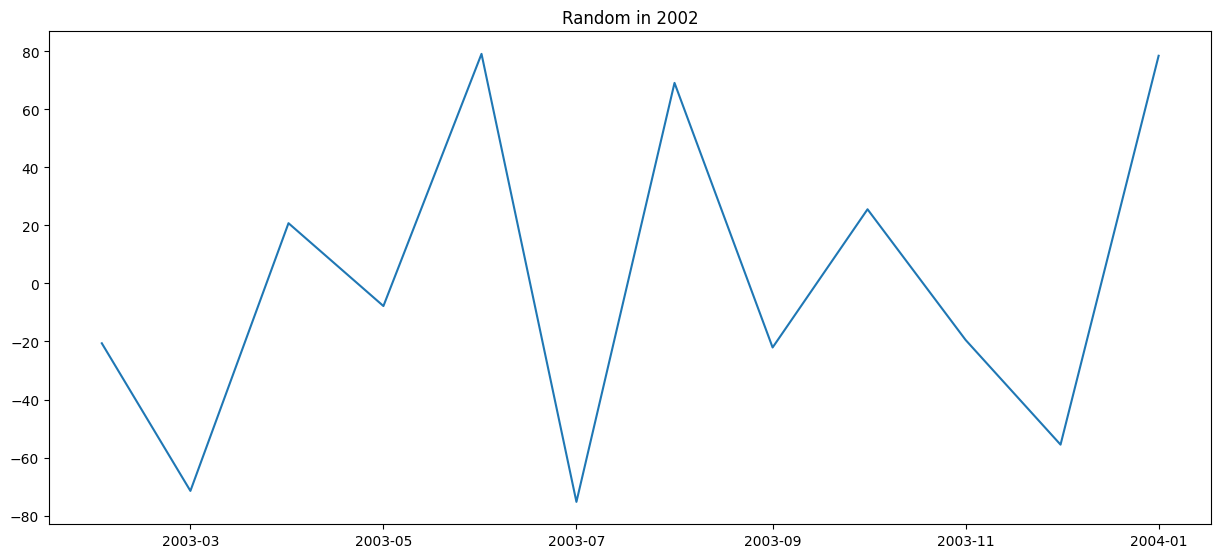

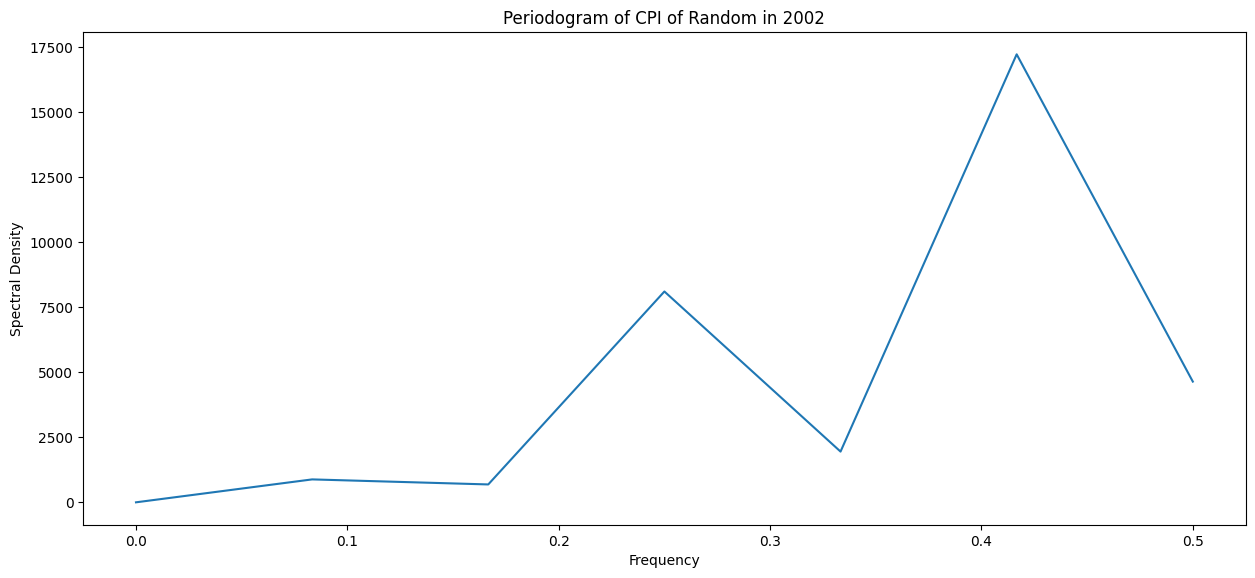

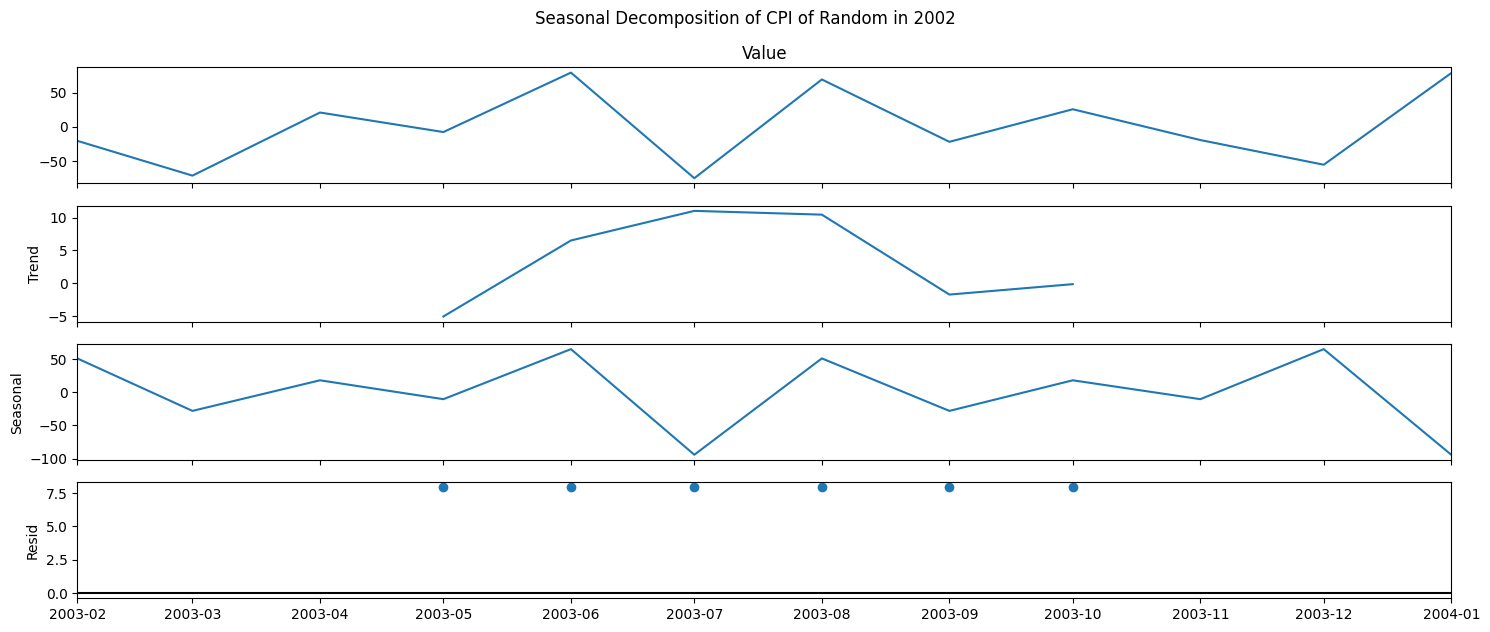

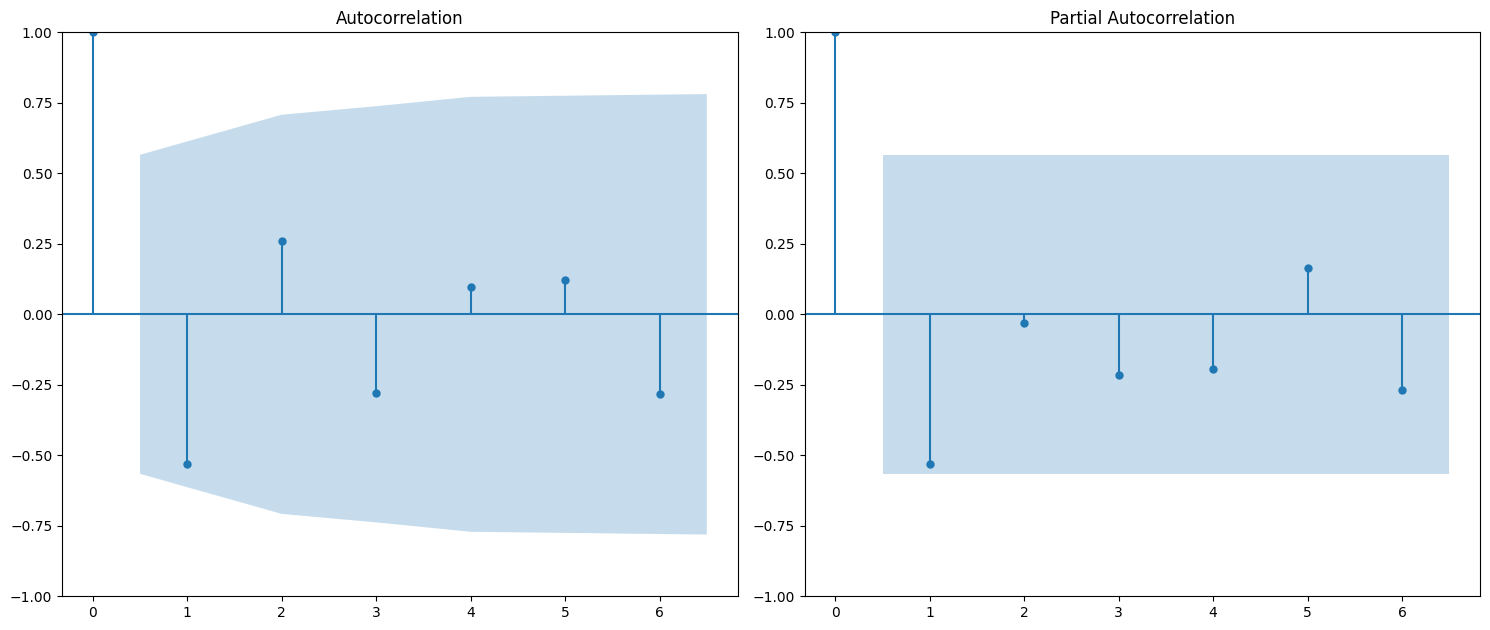

In [60]:
seasonal_analyze(df["Value"].diff().dropna(), name, "20years", period=12, time_flag="20 years", model="additive")
seasonal_analyze(df["Value"].diff().dropna()[12:24], name, 2002, period=6, time_flag=2002, model="additive")

## Mass runner

Generate a bunch of graph from the data list

In [ ]:
for file in data_files:
    df, name = read_data(file)
    seasonal_analyze(df["Change"], name, f"{df.index.year.max() - df.index.year.min()}years", period=12, time_flag=f"{df.index.year.max() - df.index.year.min()} year(s)", model="additive", save=True)
    for i in range(1, 22):
        try:
            seasonal_analyze(df[(i - 1) * 12 : i * 12]["Change"], name, i + 2001, period=6, time_flag=i + 2001, model="additive", save=True)
        except:
            pass

    